<a href="https://colab.research.google.com/github/vatsal-ts/Assignments-CSE/blob/main/CS561_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pomegranate==0.14.9
!pip install graphviz
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install memory_profiler

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pomegranate import *
import time

# Exercise 1

## Part A

In [ ]:
# info from assignment

# P(T)=0.05

# P(OD)=0.7

# P(FP|T)=0.88
# P(FP|!T)=0.0001

# P(OP|OD)=0.4
# P(OP|!OD)=0.05

# P(F|OP,FP)=0.995
# P(F|OP,!FP)=0.8
# P(F|!OP,FP)=0.85
# P(F|!OP,!FP)=0.75

In [ ]:
travel = DiscreteDistribution( { 'True' : 0.05, 'False' : 0.95 })
ownsDevice = DiscreteDistribution( { 'True' : 0.7, 'False' : 0.3 })
foreignPurchase = ConditionalProbabilityTable(
    [[ 'True', 'True', 0.88 ],
     [ 'True', 'False', 0.12 ],
     [ 'False', 'True', 0.0001 ],
     [ 'False', 'False', 0.9999 ]], [travel])
onlinePurchase = ConditionalProbabilityTable(
    [[ 'True', 'True', 0.4 ],
     [ 'True', 'False', 0.6 ],
     [ 'False', 'True', 0.05 ],
     [ 'False', 'False', 0.95 ]], [ownsDevice])
fraud = ConditionalProbabilityTable(
    [[ 'True', 'True', 'True',  0.995],
     [ 'True', 'True', 'False',  0.005],
     [ 'True', 'False', 'True', 0.8 ],
     [ 'True', 'False', 'False', 0.2 ],
     [ 'False', 'True', 'True', 0.85 ],
     [ 'False', 'True', 'False', 0.15 ],
     [ 'False', 'False', 'True', 0.75 ],
     [ 'False', 'False', 'False', 0.25 ]], [onlinePurchase, foreignPurchase])

In [ ]:
# defining the states for bayesian network
s0 = State(travel, name="travel")
s1 = State(ownsDevice, name="ownsDevice")
s2 = State(foreignPurchase, name="foreignPurchase")
s3 = State(onlinePurchase, name="onlinePurchase")
s4 = State(fraud, name="fraud")
network=BayesianNetwork("Fraud Network")
network.add_nodes(s0, s1, s2, s3, s4)
network.add_edge(s0,s2)
network.add_edge(s1,s3)
network.add_edge(s3,s4)
network.add_edge(s2,s4)

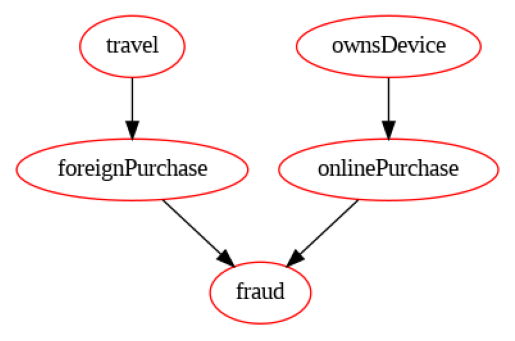

In [ ]:
network.bake()
network.plot()

## Part B

### Variable elimination method

In [ ]:
# custom class to store probability table
class ProbabilityTable:
  def __init__(self, variables):
    self.name = ""
    self.variables = variables
    self.variablesList = list(variables)
    self.table = {}
    self.constant=-1

  # creating a unique hash value for each configuration of boolean variables
  def configToNum(self,config):
    num=0
    for variable in self.variablesList:
      num*=2
      if(config[variable]):
        num+=1
    return num

  def get_probability(self, config):
    if(len(self.variables)==0):
      return self.constant
    num=self.configToNum(config)
    if num not in self.table:
      raise ValueError("Invalid configuration: {}".format(config))
    return self.table[num]

  def set_probability(self, config, probability):
    if not all(isinstance(v, bool) for v in config.values()):
      raise ValueError("All variables must be boolean.")
    self.table[self.configToNum(config)] = probability

  def instantiateVariables(self,instantiateConfig):
    instCommonVariables={}
    newVariables=(self.variables).copy()
    for key,val in instantiateConfig.items():
      if(key in self.variables):
        instCommonVariables[key]=val
        newVariables.remove(key)
    newpt=ProbabilityTable(newVariables)
    if(len(newVariables)==0):
      newpt.constant=self.get_probability(instCommonVariables)
      return newpt
    total_rows=2**(len(newVariables))
    variablesList=list(newVariables)
    for i in range(total_rows):
      curr_config={}
      config_in_original=instCommonVariables.copy()
      config_int=i
      for j in range(len(newVariables)):
        bit=config_int%2
        curr_config[variablesList[j]]=True if bit==1 else False
        config_in_original[variablesList[j]]=True if bit==1 else False
        config_int=config_int//2
      newpt.set_probability(curr_config,self.get_probability(config_in_original))
    return newpt

# perform pointwise multiplication of two factors
def pointwiseMultiply(pt1,pt2):
  newVariables=(pt1.variables).union(pt2.variables)
  pt=ProbabilityTable(newVariables)
  total_rows=2**(len(newVariables))
  variablesList=list(newVariables)

  if(len(pt1.variables)==0 and len(pt2.variables)==0):
    pt.constant=pt1.constant*pt2.constant
  for i in range(total_rows):
    curr_config={}
    config_int=i
    for j in range(len(newVariables)):
      bit=config_int%2
      curr_config[variablesList[j]]=True if bit==1 else False
      config_int=config_int//2
    config1={}
    config2={}
    for variable in variablesList:
      if(variable in pt1.variables):
        config1[variable]=curr_config[variable]
      if(variable in pt2.variables):
        config2[variable]=curr_config[variable]
    pt.set_probability(curr_config,(pt1.get_probability(config1)*pt2.get_probability(config2)))
  return pt

# to take sum over a variable in probability table
def sumOverVariable(pt,variable):
  if(variable not in pt.variables):
    return pt
  if(len(pt.variables)==1):
    # the variable is the only one
    newpt=ProbabilityTable(set())
    config1={variable:True}
    config2={variable:False}
    newpt.constant=pt.get_probability(config1)+pt.get_probability(config2)
    return newpt

  newVariables=(pt.variables).copy()
  newVariables.remove(variable)
  newpt=ProbabilityTable(newVariables)
  total_rows=2**(len(newVariables))
  variablesList=list(newVariables)
  for i in range(total_rows):
    curr_config={}
    config_int=i
    for j in range(len(newVariables)):
      bit=config_int%2
      curr_config[variablesList[j]]=True if bit==1 else False
      config_int=config_int//2
    config1=curr_config.copy()
    config2=curr_config.copy()
    config1[variable]=True
    config2[variable]=False
    newpt.set_probability(curr_config,(pt.get_probability(config1)+pt.get_probability(config2)))
  return newpt

In [ ]:
# various print statements to show steps
def getVariablesString(variables):
  s=""
  for var in variables:
    s+=var+","
  if(len(s)!=0 and s[-1]==','):
    s=s[:-1]
  return s

def getToBeEvaluatedString(newFactorList,summationVariables):
  s=""
  for var in summationVariables:
    s="\u03A3"+var+s
  s+=" "
  for factor in newFactorList:
    s+=factor.name+f"({getVariablesString(factor.variables)})"+" "
  s=f"\u03B1*{s}"
  return s

def getPrefix(independentFactors,summationVariables):
  currSummation=summationVariables[0]
  s="\u03A3"+currSummation
  indString=""
  sumString=""
  for factor in independentFactors:
    indString+=f"{factor.name}({getVariablesString(factor.variables)}) "
  s=indString + s

  if(len(summationVariables)!=1):
    summationVariables=summationVariables[1:]
    for var in summationVariables:
      sumString="\u03A3"+var+sumString
  s=sumString+" "+s
  s=f"\u03B1*{s}"
  return s

def getIndFactorsString(independentFactors):
  s=""
  for factor in independentFactors:
    s+=f"{factor.name}({getVariablesString(factor.variables)}),"
  if(len(s)!=0 and s[-1]==','):
    s=s[:-1]
  return s

# pointwise multiplication of multiple factors
def multiplyFactors(factors,count,prefix=None,showSteps=True):
  if(len(factors)==0):
    return None
  if(showSteps):
    s=prefix+" "
    for factor in factors:
      s+=factor.name+f"({getVariablesString(factor.variables)})"+" "
    print(f"Expression to be evaluated: {s}")
  while(len(factors)!=1):
    factor1=factors.pop()
    factor2=factors.pop()
    factor3=pointwiseMultiply(factor1,factor2)
    factor3.name=f"f{count}"
    count+=1
    factors.append(factor3)
    if(showSteps):
      print(f"Multiplying {factor1.name}({getVariablesString(factor1.variables)}) and {factor2.name}({getVariablesString(factor2.variables)})")
      s=prefix+" "
      for factor in factors:
        s+=factor.name+f"({getVariablesString(factor.variables)})"+" "
      print(f"Resultant expression: {s}")

  return factors[0],count

# variable elimination method
def variableElimination(queryVariables,evidenceVariables,allVariables,factorList):
  # factor list is the probability tables of factors that we get applying the bayesian network independencies
  # on joint probability ditribution
  hiddenVariables=set()
  count=1
  for var in allVariables:
    if(var not in queryVariables.keys() and var not in evidenceVariables.keys()):
      hiddenVariables.add(var)
  print(f"Evaluating P({queryVariables}|{evidenceVariables})=\u03B1*P({queryVariables},{evidenceVariables})")
  print(f"Considering hidden variables: {hiddenVariables}")

  # instantiating the known variables
  newFactorList=[]
  for factor in factorList:
    # instVariables=queryVariables.copy()
    # instVariables.update(evidenceVariables)
    instVariables=evidenceVariables
    newFactor=factor.instantiateVariables(instVariables)
    newFactor.name=f"f{count}"
    count+=1
    newFactorList.append(newFactor)

  summationVariables=list(hiddenVariables)
  print(f"after substituting instantiated variables we get: {getToBeEvaluatedString(newFactorList,summationVariables)}")
  for i in range(len(summationVariables)):
    print(f"expression to be evaluated: {getToBeEvaluatedString(newFactorList,summationVariables[i:])}")
    summationVariable=summationVariables[i]
    dependentFactors=[]
    independentFactors=[]
    for factor in newFactorList:
      if(summationVariable in factor.variables):
        dependentFactors.append(factor)
      else:
        independentFactors.append(factor)
    print(f"{getIndFactorsString(independentFactors)} are independent of innermost summation variable {summationVariable} and hence can be taken out of summation")
    prefix=getPrefix(independentFactors,summationVariables[i:])
    finalFactor,count=multiplyFactors(dependentFactors,count,prefix)
    if(finalFactor==None):
      newFactorList=independentFactors
    else:
      # if(len(finalFactor.variables)==1):
      #   newFactorList=independentFactors
      # else:
      print(f"Summing factor {finalFactor.name} over variable {summationVariable}")
      finalFactor=sumOverVariable(finalFactor,summationVariable)
      finalFactor.name=f"f{count}"
      count+=1
      independentFactors.append(finalFactor)
      newFactorList=independentFactors
  if(len(newFactorList)!=1):
    print("All summations done")
    finalFactor,count=multiplyFactors(newFactorList,count,"\u03B1*")

  oneByAlpha=0
  for key,val in finalFactor.table.items():
    oneByAlpha+=val
  print(f"\u2234 P({queryVariables}|{evidenceVariables}) = {finalFactor.get_probability(queryVariables)/oneByAlpha}")

In [ ]:
def shortenName(name):
  if(name=="travel"):
    return "T"
  elif(name=="foreignPurchase"):
    return "FP"
  elif(name=="onlinePurchase"):
    return "OP"
  elif(name=="ownsDevice"):
    return "OD"
  elif(name=="fraud"):
    return "F"
  else:
    return name

def getInstVariables(varNames,currSetting):
  instVar={}
  for i in range(len(varNames)):
    currVar=varNames[i]
    currVal=currSetting[i]
    if(currVal=="True"):
      instVar[currVar]=True
    else:
      instVar[currVar]=False
  return instVar

# to get list of factors from bayesian network
def getFactorsList(network):
  factorsList=[]
  for i in range(len(network.states)):
    node=network.states[i]
    name=shortenName(node.name)
    # print(node)
    if(node.distribution.name == "DiscreteDistribution"):
      newFactor=ProbabilityTable({name})
      newFactor.name=name
      newFactor.set_probability({name:True},node.distribution.parameters[0]["True"])
      newFactor.set_probability({name:False},node.distribution.parameters[0]["False"])
    else:
      parentIndices=network.structure[i]
      parentNames=[]
      for index in parentIndices:
        parentNames.append(shortenName(network.states[index].name))
      factorVariableNames=parentNames
      factorVariableNames.append(name)
      newFactor=ProbabilityTable(set(factorVariableNames))
      newFactor.name=name
      # print(node.distribution.parameters)
      for i in range(len(node.distribution.parameters[0])):
        pValue=node.distribution.parameters[0][i][-1]
        currSetting=node.distribution.parameters[0][i][:-1]
        instVariables=getInstVariables(factorVariableNames,currSetting)
        # print(f"{instVariables}: {pValue}")
        newFactor.set_probability(instVariables,pValue)
    factorsList.append(newFactor)
  return factorsList

In [ ]:
# new version
%load_ext memory_profiler
factorsList=getFactorsList(network)
factorsNames=[factor.name for factor in factorsList]
varElimTimeInitial=time.time()
m1=%memit -o variableElimination({'F':True},{},factorsNames,factorsList)
print("---------------------------------------------------------------")
m2=%memit -o variableElimination({'F':True},{'OD':True},factorsNames,factorsList)
print("---------------------------------------------------------------")
# considering all queries to be independent
m3=%memit -o variableElimination({'F':True},{'T':True},factorsNames,factorsList)
print("---------------------------------------------------------------")
# considering all queries to be successive
m4=%memit -o variableElimination({'F':True},{'T':True,'OD':True},factorsNames,factorsList)
print("---------------------------------------------------------------")
varElimTimeFinal=time.time()
print(f"Time taken: {varElimTimeFinal-varElimTimeInitial}")
print(f"Average peak memory: {(m1.mem_usage[0] +m2.mem_usage[0]+m3.mem_usage[0]+m4.mem_usage[0])/4}")

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
Evaluating P({'F': True}|{})=α*P({'F': True},{})
Considering hidden variables: {'T', 'FP', 'OP', 'OD'}
after substituting instantiated variables we get: α*ΣODΣOPΣFPΣT f1(T) f2(OD) f3(T,FP) f4(OP,OD) f5(F,OP,FP) 
expression to be evaluated: α*ΣODΣOPΣFPΣT f1(T) f2(OD) f3(T,FP) f4(OP,OD) f5(F,OP,FP) 
f2(OD),f4(OP,OD),f5(F,OP,FP) are independent of innermost summation variable T and hence can be taken out of summation
Expression to be evaluated: α*ΣODΣOPΣFP f2(OD) f4(OP,OD) f5(F,OP,FP) ΣT f1(T) f3(T,FP) 
Multiplying f3(T,FP) and f1(T)
Resultant expression: α*ΣODΣOPΣFP f2(OD) f4(OP,OD) f5(F,OP,FP) ΣT f6(T,FP) 
Summing factor f6 over variable T
expression to be evaluated: α*ΣODΣOPΣFP f2(OD) f4(OP,OD) f5(F,OP,FP) f7(FP) 
f2(OD),f4(OP,OD) are independent of innermost summation variable FP and hence can be taken out of summation
Expression to be evaluated: α*ΣODΣOP f2(OD) f4(OP,OD) ΣFP f5(F,OP,FP) 

### Gibbs sampling

In [ ]:
varNameToFactorDict={}
initialConfig={}
for i in range(len(factorsNames)):
  f=factorsNames[i]
  u1=random.uniform(0, 1)
  if(u1<0.5):
    initialConfig[f]=True
  else:
    initialConfig[f]=False
  varNameToFactorDict[f]=factorsList[i]

In [ ]:
# to check whether the two configs are not contradictory
def matchingConfig(subsetConfig,config):
  for key,val in subsetConfig.items():
    if(config[key]!=val):
      return False
  return True

# Gibbs sampling method
def gibbsSampling(queryVariables,evidenceVariables,numSamples,initialConfig,varList,varNameToFactorDict):
  curr_config=initialConfig.copy()
  print(f"Initial config of variables: {initialConfig}")
  numeratorVariables=queryVariables.copy()
  numeratorVariables.update(evidenceVariables)
  denominatorVariables=evidenceVariables
  numerator=0
  denominator=0
  for i in range(numSamples):
    r=random.randint(0, len(varList)-1)
    # print(f"Selected variable: {varList[r]}")
    curr_factor=varNameToFactorDict[varList[r]]
    config_for_factor={}
    for var in curr_factor.variables:
      config_for_factor[var]=curr_config[var]
    # we calculate the probability of current config repeating
    p_repeat=curr_factor.get_probability(config_for_factor)
    u=random.uniform(0, 1)
    if(u>p_repeat):
      # do not repeat
      curr_config[varList[r]]=not curr_config[varList[r]]
    if(matchingConfig(numeratorVariables,curr_config)):
      numerator+=1
    if(matchingConfig(denominatorVariables,curr_config)):
      denominator+=1
    print(f"New sample configuration: {curr_config}")
  if(denominator!=0):
    print(f"\u2234 P({queryVariables}|{evidenceVariables}) = {numerator/denominator}")
  else:
    print("Take larger number of samples")

In [ ]:
n_samples=100
# gibbsSampling({'F':True},{},500000,initialConfig,['T','OD','OP','FP','F'],varNameToFactorDict)
# gibbsSampling({'F':True},{'OD':True},500000,initialConfig,['T','OD','OP','FP','F'],varNameToFactorDict)
# gibbsSampling({'F':True},{'T':True},500000,initialConfig,['T','OD','OP','FP','F'],varNameToFactorDict)
gibbsTimeInitial=time.time()
m1=%memit -o gibbsSampling({'F':True},{},n_samples,initialConfig,factorsNames,varNameToFactorDict)
print("---------------------------------------------------------------")
m2=%memit -o gibbsSampling({'F':True},{'OD':True},n_samples,initialConfig,factorsNames,varNameToFactorDict)
print("---------------------------------------------------------------")
# considering all queries to be independent
m3=%memit -o gibbsSampling({'F':True},{'T':True},n_samples,initialConfig,factorsNames,varNameToFactorDict)
print("---------------------------------------------------------------")
# considering all queries to be successive
m4=%memit -o gibbsSampling({'F':True},{'T':True,'OD':True},n_samples,initialConfig,factorsNames,varNameToFactorDict)
print("---------------------------------------------------------------")
gibbsTimeFinal=time.time()
print(f"Time taken: {gibbsTimeFinal-gibbsTimeInitial}")
print(f"Average peak memory: {(m1.mem_usage[0]+m2.mem_usage[0]+m3.mem_usage[0]+m4.mem_usage[0])/4}")

Initial config of variables: {'T': True, 'OD': True, 'FP': True, 'OP': True, 'F': False}
New sample configuration: {'T': True, 'OD': True, 'FP': True, 'OP': True, 'F': False}
New sample configuration: {'T': True, 'OD': True, 'FP': True, 'OP': True, 'F': True}
New sample configuration: {'T': True, 'OD': True, 'FP': True, 'OP': True, 'F': True}
New sample configuration: {'T': True, 'OD': True, 'FP': True, 'OP': False, 'F': True}
New sample configuration: {'T': True, 'OD': True, 'FP': True, 'OP': False, 'F': True}
New sample configuration: {'T': True, 'OD': True, 'FP': True, 'OP': False, 'F': True}
New sample configuration: {'T': True, 'OD': True, 'FP': True, 'OP': False, 'F': True}
New sample configuration: {'T': False, 'OD': True, 'FP': True, 'OP': False, 'F': True}
New sample configuration: {'T': False, 'OD': True, 'FP': True, 'OP': False, 'F': True}
New sample configuration: {'T': False, 'OD': False, 'FP': True, 'OP': False, 'F': True}
New sample configuration: {'T': False, 'OD': Fals

# Exercise 2


In [ ]:
# calculate phat
def phat(x):
  ex=math.exp(-(x**4))
  trig=(2+math.sin(5*x)+math.sin(-2*(x**2)))
  return (ex*trig)

In [ ]:
# calculate acceptance probability
def acceptanceProbability(xCand,xPrev,stdDev):
  num=norm.pdf(xPrev, loc=xCand, scale=stdDev) * phat(xCand)
  den=norm.pdf(xCand, loc=xPrev, scale=stdDev) * phat(xPrev)
  return min(1,(num/den))

In [ ]:
# Metropolis Hastings method
def metropolisHastings(x0,iterations,stdDev):
  xPrev=x0
  samples=[]
  for i in range(iterations):
    # choose candidate from gaussian distribution
    xCand = np.random.normal(xPrev, stdDev)
    alpha=acceptanceProbability(xCand,xPrev,stdDev)
    u=random.uniform(0, 1)
    if(u<alpha):
      xPrev=xCand
    samples.append(xPrev)
  return samples

In [ ]:
# make required plots
def makePlots(x0,iterations,stdDev):
  samples=metropolisHastings(x0,iterations,stdDev)

  # plot line graph
  plt.xlabel("Iteration")
  plt.ylabel("Sample value")
  plt.title(f"Generated sample versus Iteration(Standard deviation={stdDev})")
  plt.plot(range(1,len(samples)+1), samples)  # Plot the chart
  plt.show()  # display

  # plot histogram
  plt.xlabel("Sample value")
  plt.ylabel("Frequency")
  plt.title(f"Histogram of generated samples(Standard deviation={stdDev})")
  plt.hist(samples,bins=20)
  plt.show()  # display

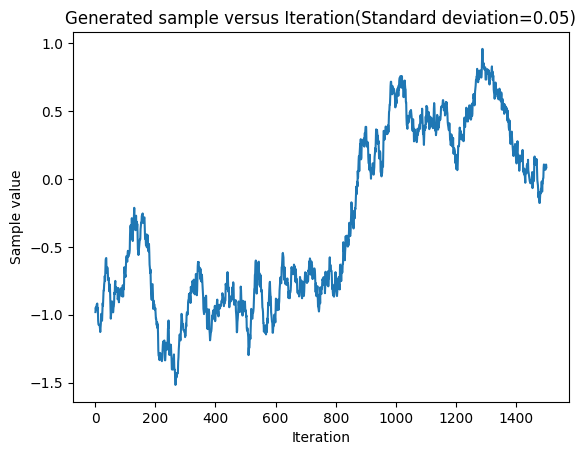

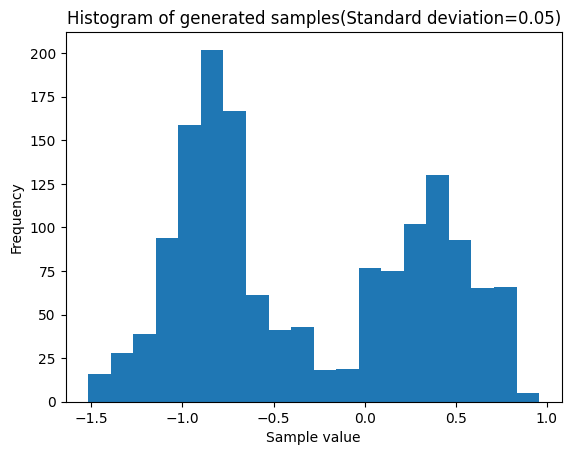

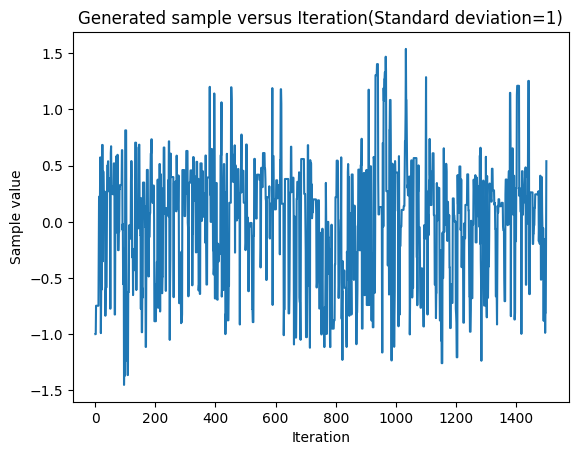

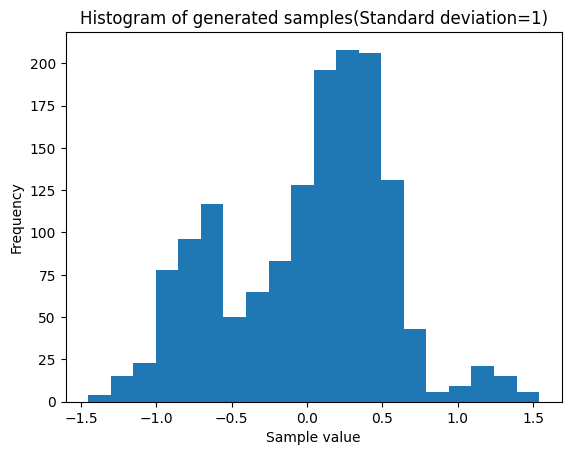

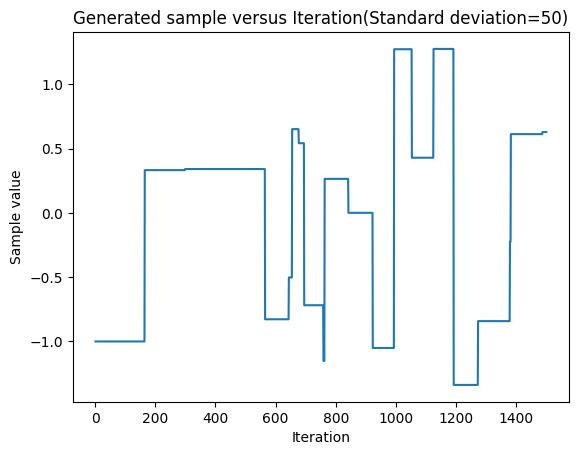

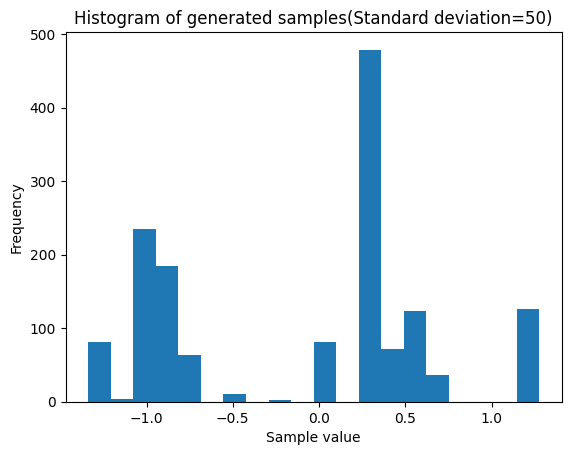

In [ ]:
x0=-1
iterations=1500
stdDevValues=[0.05,1,50]

for stdDev in stdDevValues:
  makePlots(x0,iterations,stdDev)